In [ ]:
import os
import sys
import numpy as np
import torch
from datetime import datetime
from torchvision import transforms
from omegaconf import OmegaConf
import argparse
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

from monai.networks.nets import UNet
from clue import CLUESampling

sys.path.append('../')
from data_utils import MNMv2DataModule
from unet import LightningSegmentationModel
from torch.utils.data import Dataset

# TODO: Add weights and remove later
class MNMv2Subset(Dataset):
    def __init__(
        self,
        input,
        target,
        weight
    ):
        self.input = input
        self.target = target
        self.weight = weight

    def __len__(self):
        return self.input.shape[0]
    
    def __getitem__(self, idx):
        return {
            "input": self.input[idx], 
            "target": self.target[idx],
            "weight": self.weight[idx]
        }

def str2bool(v):
    if isinstance(v, bool):
        return v
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')

if __name__ == '__main__':
    parser = argparse.ArgumentParser(description="Training or loading a model.")
    parser.add_argument('--train', type=str2bool, nargs='?', const=True, default=True, help="Whether to train the model")
    parser.add_argument('--n', type=int, default=4, help="Number of clusters.")
    parser.add_argument('--clue_softmax_t', type=float, default=0.1, help="Temperature.")
    parser.add_argument('--adapt_num_epochs', type=int, default=5, help="Number epochs for finetuning.")
    parser.add_argument('--cluster_type', type=str, default='centroids', help="This parameter determines whether we will train our model on centroids or on the most confident data close to centroids.")
    parser.add_argument('--checkpoint_path', type=str, default='../../MedImSeg-Lab24/pre-trained/trained_UNets/mnmv2-15-54_09-12-2024-v1.ckpt', 
                        help="Path to the model checkpoint.")
    parser.add_argument('--device', type=str, default='cuda:0', help="Device to use for training (e.g., 'cuda:0', 'cuda:1', or 'cpu').")
    args = parser.parse_args()

    mnmv2_config   = OmegaConf.load('../../MedImSeg-Lab24/configs/mnmv2.yaml')
    unet_config    = OmegaConf.load('../../MedImSeg-Lab24/configs/monai_unet.yaml')
    trainer_config = OmegaConf.load('../../MedImSeg-Lab24/configs/unet_trainer.yaml')

    # init datamodule
    datamodule = MNMv2DataModule(
        data_dir=mnmv2_config.data_dir,
        vendor_assignment=mnmv2_config.vendor_assignment,
        batch_size=mnmv2_config.batch_size,
        binary_target=mnmv2_config.binary_target,
        non_empty_target=mnmv2_config.non_empty_target,
        split_ratio=0.5
    )

    cfg = OmegaConf.create({
        'unet_config': unet_config,
        'binary_target': True if unet_config.out_channels == 1 else False,
        'lr': unet_config.lr,
        'patience': unet_config.patience,
        'adapt_num_epochs': args.adapt_num_epochs,
        'cluster_type': args.cluster_type,
        'clue_softmax_t': args.clue_softmax_t,
        'dataset': OmegaConf.to_container(mnmv2_config),
        'unet': OmegaConf.to_container(unet_config),
        'trainer': OmegaConf.to_container(trainer_config),
    })

    if args.train:
        model = LightningSegmentationModel(cfg=cfg)
        
        now = datetime.now()
        filename = 'mnmv2-' + now.strftime("%H-%M_%d-%m-%Y")

        trainer = L.Trainer(
            limit_train_batches=trainer_config.limit_train_batches,
            max_epochs=trainer_config.max_epochs,
            callbacks=[
                EarlyStopping(
                    monitor=trainer_config.early_stopping.monitor, 
                    mode=trainer_config.early_stopping.mode, 
                    patience=unet_config.patience * 2
                ),
                ModelCheckpoint(
                    dirpath=trainer_config.model_checkpoint.dirpath,
                    filename=filename,
                    save_top_k=trainer_config.model_checkpoint.save_top_k, 
                    monitor=trainer_config.model_checkpoint.monitor,
                )
            ],
            precision='16-mixed',
            gradient_clip_val=0.5,
            devices=[0]
        )

        trainer.fit(model, datamodule=datamodule)

    else:
        #TODO: Add argsparse
        load_as_lightning_module = True #False
        load_as_pytorch_module = False #True

        if load_as_lightning_module:
            unet_config    = OmegaConf.load('../../MedImSeg-Lab24/configs/monai_unet.yaml')
            unet = UNet(
                spatial_dims=unet_config.spatial_dims,
                in_channels=unet_config.in_channels,
                out_channels=unet_config.out_channels,
                channels=[unet_config.n_filters_init * 2 ** i for i in range(unet_config.depth)],
                strides=[2] * (unet_config.depth - 1),
                num_res_units=4
            )
            
            model = LightningSegmentationModel.load_from_checkpoint(
                args.checkpoint_path,
                map_location=torch.device("cpu"),
                model=unet,
                binary_target=True if unet_config.out_channels == 1 else False,
                lr=unet_config.lr,
                patience=unet_config.patience,
                cfg=cfg
            )

        elif load_as_pytorch_module:
            checkpoint = torch.load(args.checkpoint_path, map_location=torch.device("cpu"))
            model_state_dict = checkpoint['state_dict']
            model_state_dict = {k.replace('model.model.', 'model.'): v for k, v in model_state_dict.items() if k.startswith('model.')}
            model_config = checkpoint['hyper_parameters']['cfgs']

            print(model_config)

            model = UNet(
                spatial_dims=model_config['unet']['spatial_dims'],
                in_channels=model_config['unet']['in_channels'],
                out_channels=model_config['unet']['out_channels'],
                channels=[model_config['unet']['n_filters_init'] * 2 ** i for i in range(model_config['unet']['depth'])],
                strides=[2] * (model_config['unet']['depth'] - 1),
                num_res_units=4
            )

            model.load_state_dict(model_state_dict)
    
    device = torch.device(args.device if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Getting the most uncertainty features
    datamodule.setup(stage='fit')
    train_idx = np.arange(len(datamodule.mnm_train))
    clue_sampler = CLUESampling(dset=datamodule.mnm_train,
                                train_idx=train_idx, 
                                model=model, 
                                device=device, 
                                args=cfg)
    # Getting centroids / nearest points to centroids
    nearest_idx = clue_sampler.query(n=args.n)
    selected_samples = [datamodule.mnm_train[i] for i in nearest_idx]
    
    # transform = transforms.Compose([
    #     transforms.RandomRotation(30),
    #     transforms.RandomHorizontalFlip(),
    #     transforms.ColorJitter(brightness=0.2, contrast=0.2),
    #     ])
    
    # augmented_centroids = [transform(sample) for sample in selected_samples]
    # Getting results BEFORE using CLUE
    datamodule.setup(stage='test')
    test_loader = datamodule.test_dataloader()
    start_loss  = model.test_model(test_loader, device)

    # Fine-tuning the model
    # Extend train data by test samples with the highest uncertainty
    datamodule.setup(stage='fit')

    # weighted_dataset = WeightedDataset(inputs_combined, targets_combined, weights_combined)

    selected_inputs = torch.stack([sample["input"] for sample in selected_samples])
    selected_targets = torch.stack([sample["target"] for sample in selected_samples])

    train2_classes = datamodule.mnm_train2.target.argmax(dim=1)  # Если one-hot, преобразуйте к меткам
    train2_class_distribution = torch.bincount(train2_classes)
    print("Train2 class distribution:", train2_class_distribution)

    centroids_classes = selected_targets.argmax(dim=1)  # Если one-hot, преобразуйте к меткам
    centroids_class_distribution = torch.bincount(centroids_classes)
    print("Centroid class distribution:", centroids_class_distribution)


    # Combining input data and labels (train2 + clue)
    combined_inputs = torch.cat([datamodule.mnm_train2.input, selected_inputs], dim=0)
    combined_targets = torch.cat([datamodule.mnm_train2.target, selected_targets], dim=0)

    weights_train2 = torch.ones(len(datamodule.mnm_train2))
    weights_new_points = torch.full((len(selected_samples),), 2.0)
    weights_combined = torch.cat([weights_train2, weights_new_points], dim=0)

    combined_data = MNMv2Subset(
        input=combined_inputs,
        target=combined_targets,
        weight=weights_combined
    )
    new_model = clue_sampler.finetune_model(combined_data, datamodule.mnm_val)

    if args.cluster_type == 'centroids':
        save_dir = '../pre-trained/finetuned_on_centroids'
    else:
        save_dir = '../pre-trained/finetuned_on_uncert_points'

    os.makedirs(save_dir, exist_ok=True)

    model_save_path = os.path.join(save_dir, f'fituned_model_on_{args.cluster_type}.pth')
    torch.save(model.state_dict(), model_save_path)

    # Getting results AFTER using CLUE
    datamodule.setup(stage='test')
    test_loader = datamodule.test_dataloader()
    test_perf = new_model.test_model(test_loader, device)



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

nnUNet_raw_data_base is not defined and nnU-Net can only be used on data for which preprocessed files are already present on your system. nnU-Net cannot be used for experiment planning and preprocessing like this. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up properly.
nnUNet_preprocessed is not defined and nnU-Net can not be used for preprocessing or training. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up.
RESULTS_FOLDER is not defined and nnU-Net cannot be used for training or inference. If this is not in

usage: ipykernel_launcher.py [-h] [--train [TRAIN]] [--n N]
                             [--clue_softmax_t CLUE_SOFTMAX_T]
                             [--adapt_num_epochs ADAPT_NUM_EPOCHS]
                             [--cluster_type CLUSTER_TYPE]
                             [--checkpoint_path CHECKPOINT_PATH]
                             [--device DEVICE]
ipykernel_launcher.py: error: unrecognized arguments: --f=/home/mikhelson/.local/share/jupyter/runtime/kernel-v3001163b81ce0d4318bede83be19295d5cf47a25a.json


SystemExit: 2

/home/mikhelson/MedImSeg-Lab24/CLUE/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [2]:
# # Шаг дообучения модели с использованием центроидов
# model.finetune_model_on_centroids(centroids, train_loader, model)

# # Тестируем производительность модели после дообучения
# test_perf = model.test_model(test_loader, device)
# # out_str += '\t Round 1 (B={}): {:.2f}'.format(len(cluster_centers), test_perf)

# # Выводим результаты и возвращаем производительность до и после обучения
# print(start_loss['dsc'], test_perf['dsc'])
cfg

{'unet_config': {'n_filters_init': 16, 'depth': 4, 'spatial_dims': 2, 'in_channels': 1, 'out_channels': 4, 'num_res_units': 4, 'lr': 0.001, 'patience': 5, 'clue_softmax_t': 1.0, 'batch_size': 32}, 'binary_target': False, 'lr': 0.001, 'patience': 5, 'lambda_centroids': 0.6, 'dataset': {'data_dir': '/home/mikhelson/MedImSeg-Lab24/data/MNM/', 'vendor_assignment': {'train': 'siemens', 'test': 'ge'}, 'batch_size': 32, 'binary_target': False, 'non_empty_target': False}, 'unet': {'n_filters_init': 16, 'depth': 4, 'spatial_dims': 2, 'in_channels': 1, 'out_channels': 4, 'num_res_units': 4, 'lr': 0.001, 'patience': 5, 'clue_softmax_t': 1.0, 'batch_size': 32}, 'trainer': {'train_transforms': 'global_transforms', 'limit_train_batches': 50, 'max_epochs': 100, 'early_stopping': {'monitor': 'val_loss', 'mode': 'min'}, 'model_checkpoint': {'save_top_k': 2, 'dirpath': '../../pre-trained/trained_UNets', 'monitor': 'val_loss'}, 'logging': True}}

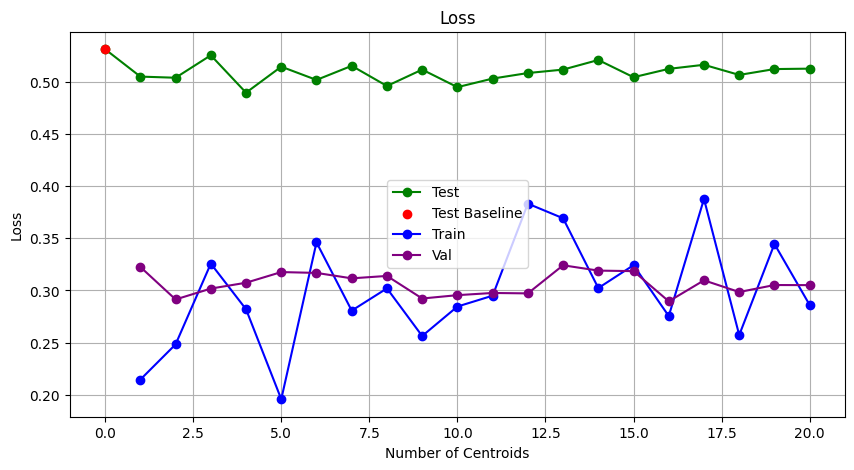

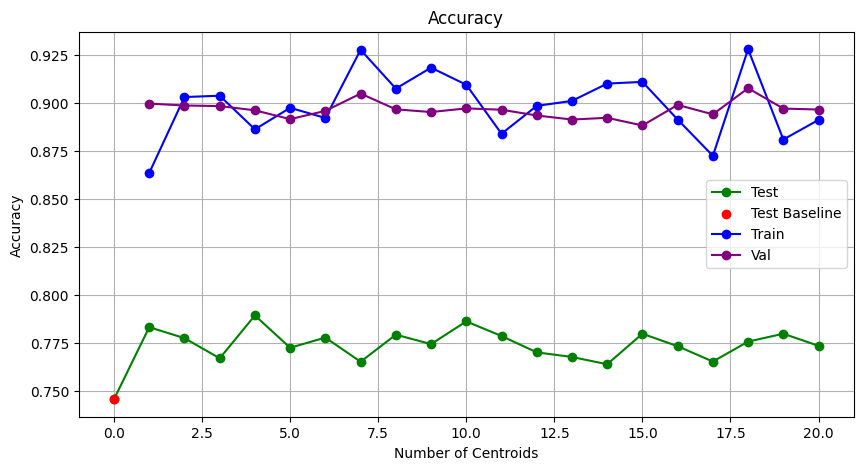

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data_path = "results_test.txt"  # Replace with your file path
data = pd.read_csv(data_path, sep="\t")

# Add baseline data
baseline = pd.DataFrame({"n_centroids": [0], "loss": [0.5309], "acc": [0.7457]})
data = pd.concat([baseline, data], ignore_index=True)
data_tr_vl = pd.read_csv('results_train_val.txt', sep='\t')
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(data["n_centroids"], data["loss"], marker="o", label="Test", color="green")
plt.scatter(0, 0.5309, color="red", label="Test Baseline", zorder=5)  # Highlight baseline
plt.plot(data_tr_vl['n_centroids'], data_tr_vl['train_loss'], marker="o", color='blue', label="Train")
plt.plot(data_tr_vl['n_centroids'], data_tr_vl['val_loss'], marker="o", color='purple', label="Val")
plt.xlabel("Number of Centroids")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(data["n_centroids"], data["acc"], marker="o", label="Test", color="green")
plt.scatter(0, 0.7457, color="red", label="Test Baseline", zorder=5)  # Highlight baseline
plt.plot(data_tr_vl['n_centroids'], data_tr_vl['train_dsc'], marker="o", color='blue', label="Train")
plt.plot(data_tr_vl['n_centroids'], data_tr_vl['val_dsc'], marker="o", color='purple', label="Val")
plt.xlabel("Number of Centroids")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


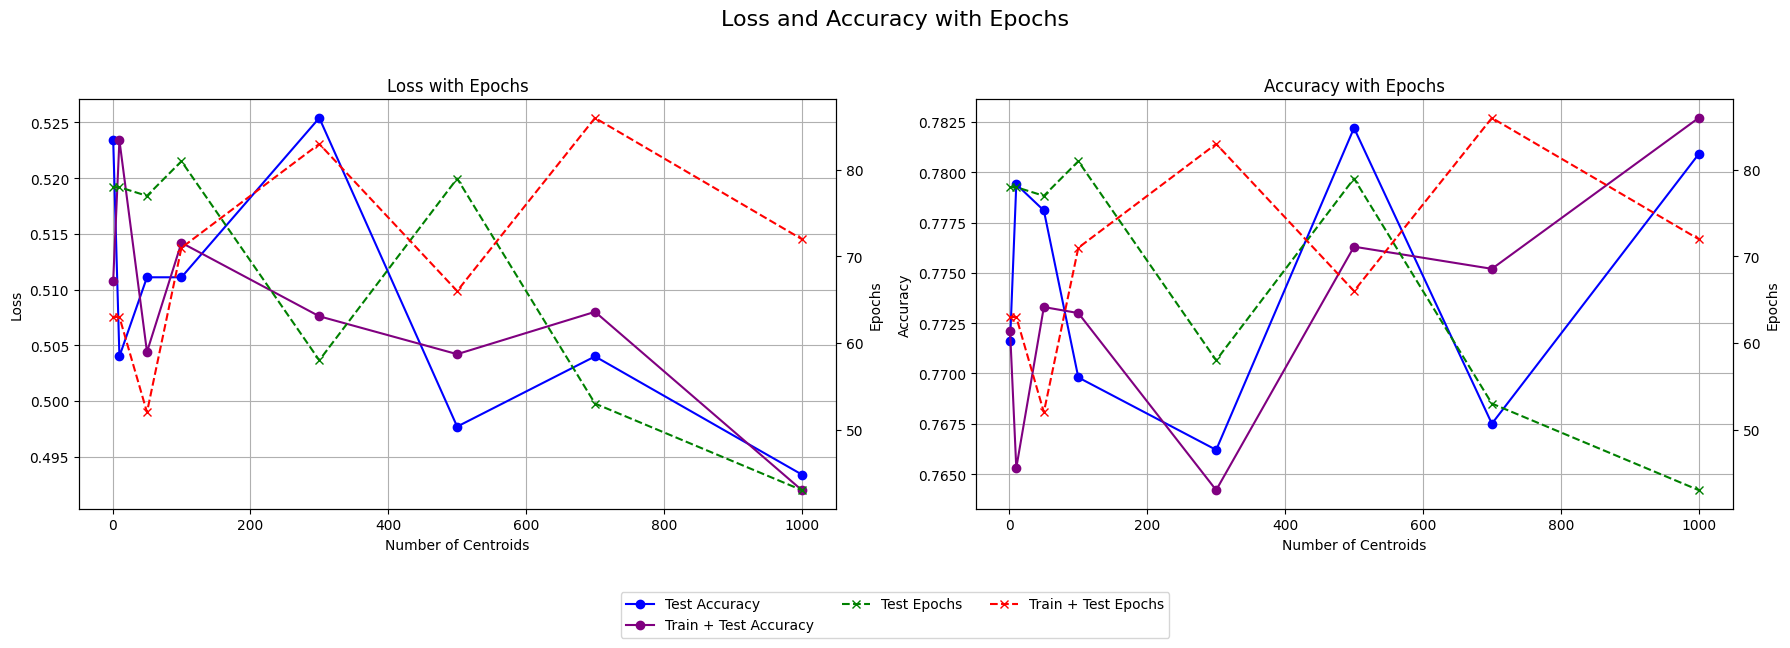

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data_test = pd.read_csv('results_only_test.txt', sep="\t")
data_tr_test = pd.read_csv('results_train_test.txt', sep='\t')

# Создаем фигуру с сеткой 1x2
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle("Loss and Accuracy with Epochs", fontsize=16)

# 1. График для Loss
ax1 = axes[0]
p1 = ax1.plot(data_test['Num_Centroids'], data_test['Loss'], marker="o", color='blue', label="Test Loss")
p2 = ax1.plot(data_tr_test['Num_Centroids'], data_tr_test['Loss'], marker="o", color='purple', label="Train + Test Loss")
ax1.set_xlabel("Number of Centroids")
ax1.set_ylabel("Loss")
ax1.tick_params(axis='y')
ax1_twin = ax1.twinx()
p3 = ax1_twin.plot(data_test['Num_Centroids'], data_test['Num_epochs'], marker="x", color='green', linestyle='--', label="Test Epochs")
p4 = ax1_twin.plot(data_tr_test['Num_Centroids'], data_tr_test['Num_epochs'], marker="x", color='red', linestyle='--', label="Train + Test Epochs")
ax1_twin.set_ylabel("Epochs")
ax1_twin.tick_params(axis='y')
ax1.set_title("Loss with Epochs")
ax1.grid(True)

# 2. График для Accuracy
ax2 = axes[1]
p1 = ax2.plot(data_test['Num_Centroids'], data_test['Dice_Score'], marker="o", color='blue', label="Test Accuracy")
p2 = ax2.plot(data_tr_test['Num_Centroids'], data_tr_test['Dice_Score'], marker="o", color='purple', label="Train + Test Accuracy")
ax2.set_xlabel("Number of Centroids")
ax2.set_ylabel("Accuracy")
ax2.tick_params(axis='y')
ax2_twin = ax2.twinx()
p3 = ax2_twin.plot(data_test['Num_Centroids'], data_test['Num_epochs'], marker="x", color='green', linestyle='--', label="Test Epochs")
p4 = ax2_twin.plot(data_tr_test['Num_Centroids'], data_tr_test['Num_epochs'], marker="x", color='red', linestyle='--', label="Train + Test Epochs")
ax2_twin.set_ylabel("Epochs")
ax2_twin.tick_params(axis='y')
ax2.set_title("Accuracy with Epochs")
ax2.grid(True)

# Легенда
plots = p1 + p2 + p3 + p4
labels = [p.get_label() for p in plots]
fig.legend(plots, labels, loc="upper center", bbox_to_anchor=(0.5, 0.02), ncol=3)

# Отображение
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()


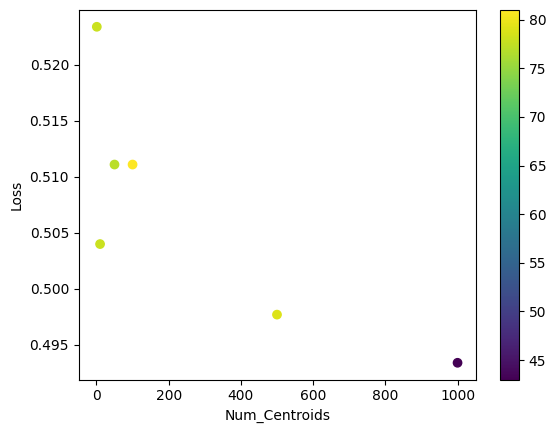

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pl

# Load the data
data_test = pd.read_csv('results_only_test.txt', sep="\t")
data_tr_test = pd.read_csv('results_train_test.txt', sep='\t')

# # Plot Loss
# fig, ax1 = plt.subplots(figsize=(10, 5))

# # Первичная ось (y-axis) для Loss
# ax1.plot(data_test['Num_Centroids'], data_test['Loss'], marker="o", color='blue', label="Test Loss")
# ax1.plot(data_tr_test['Num_Centroids'], data_tr_test['Loss'], marker="o", color='purple', label="Train + Test Loss")
# ax1.set_xlabel("Number of Centroids")
# ax1.set_ylabel("Loss", color='blue')
# ax1.tick_params(axis='y', labelcolor='blue')

# # Добавление третьей оси (Epochs)
# ax2 = ax1.twinx()
# ax2.plot(data_test['Num_Centroids'], data_test['Num_epochs'], marker="x", color='green', linestyle='--', label="Epochs")
# ax2.set_ylabel("Epochs", color='green')
# ax2.tick_params(axis='y', labelcolor='green')

# # Добавление легенды
# fig.tight_layout()
# fig.suptitle("Loss with Epochs", y=1.03)
# fig.legend(loc="upper right", bbox_to_anchor=(0.85, 0.85))
# plt.grid(True)
# plt.show()


graph = pl.scatter(data_test['Num_Centroids'], data_test['Loss'], c= data_test['Num_epochs'])

pl.xlabel('Num_Centroids')
pl.ylabel('Loss')
# pl.clabel('Num_epochs')
pl.colorbar(graph)